In [38]:
import torch
import hydra
from omegaconf import OmegaConf

import sys

sys.path.append("..")
sys.path.append("../..")


import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import torch.nn.functional as F

In [39]:
traindf = pd.read_csv("../data/processed/train.csv")

In [40]:
with hydra.initialize(config_path="../configs", version_base=None):
    # Load the specific config by name
    cfg = hydra.compose(config_name="config")
    print(cfg)


{'preprocess': {'data_path': './data', 'cta': {'window_width': 600, 'window_level': 300}, 'volume': {'depth': 256, 'height': 512, 'width': 512}}, 'optimizer': {'_target_': 'torch.optim.AdamW', 'lr': 0.0004, 'weight_decay': 0.01}, 'trainer': {'max_epochs': 64, 'accelerator': 'gpu', 'devices': 1, 'precision': '16-mixed', 'check_val_every_n_epoch': 2}, 'project_name': 'rsna-intracranial-aneurysm-detection', 'experiment': 'windowed_mip', 'seed': 42, 'fold_id': 0, 'params': {'data_path': './data/processed', 'num_classes': 14, 'sliding_stride': {'cta': 8, 'mr': 16}, 'spatial_size': {'cta': [4, 128, 128], 'mr': [32, 128, 128]}, 'img_height': 256, 'img_width': 256, 'radius': 5, 'validation': {'output_img': [1, 14, 512, 512], 'patch_size': [128, 128]}, 'batch_size': 12, 'num_workers': 16}}


In [41]:
from src.trainers.crop_classification import *
from src.rsna_datasets.crop_classification import WindowedMIPDataModule
from src.model import MultiBackboneModel
import pytorch_lightning as pl

In [42]:
dm = WindowedMIPDataModule(cfg)
model = MultiBackboneModel(
    model_name="efficientnet_b2",
    in_chans=4,
    img_size=256,
    num_classes=14,
    drop_rate=0.3,
    drop_path_rate=0.2,
    pretrained=True
)

pl_model = LitWindowedMIP.load_from_checkpoint("../models/windowed_mip_classification-epoch=03-val_loss=0.9985_fold_id=0.ckpt", model = model,cfg=cfg)
pl_model.eval()

trainer = pl.Trainer(
    **cfg.trainer,
    logger=pl.loggers.TensorBoardLogger("logs/", name=cfg.experiment),
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model efficientnet_b2: detected 1408 features, output shape: torch.Size([1, 1408, 8, 8])


In [43]:
dm.setup()

FileNotFoundError: [Errno 2] No such file or directory: 'data/processed/train.csv'

In [44]:
uid, images, masks, labels = dm.val_dataset[5]

AttributeError: 'WindowedMIPDataModule' object has no attribute 'val_dataset'

In [24]:
traindf[traindf["SeriesInstanceUID"] == uid]

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present,fold_id
6,1.2.826.0.1.3680043.8.498.10042423585566957032...,70,Female,MRA,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1


In [25]:
images.shape, masks.shape, labels.shape

(torch.Size([16, 2, 512, 512]), torch.Size([16, 512, 512]), torch.Size([14]))

In [26]:
with torch.no_grad():
    res = pl_model.validation_step((uid, images.cuda().unsqueeze(0), masks, labels.cuda().unsqueeze(0)), 0)

You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


In [27]:
res = res[:, 1:]

In [28]:
label = masks.max().item() - 1
D,y,x = torch.unravel_index(masks.argmax(), masks.shape)
D += 1

In [29]:
# label.item()
res[D].argmax(), label

(tensor(10, device='cuda:0'), 10)

In [30]:


image = images[D]
mask = masks[D]

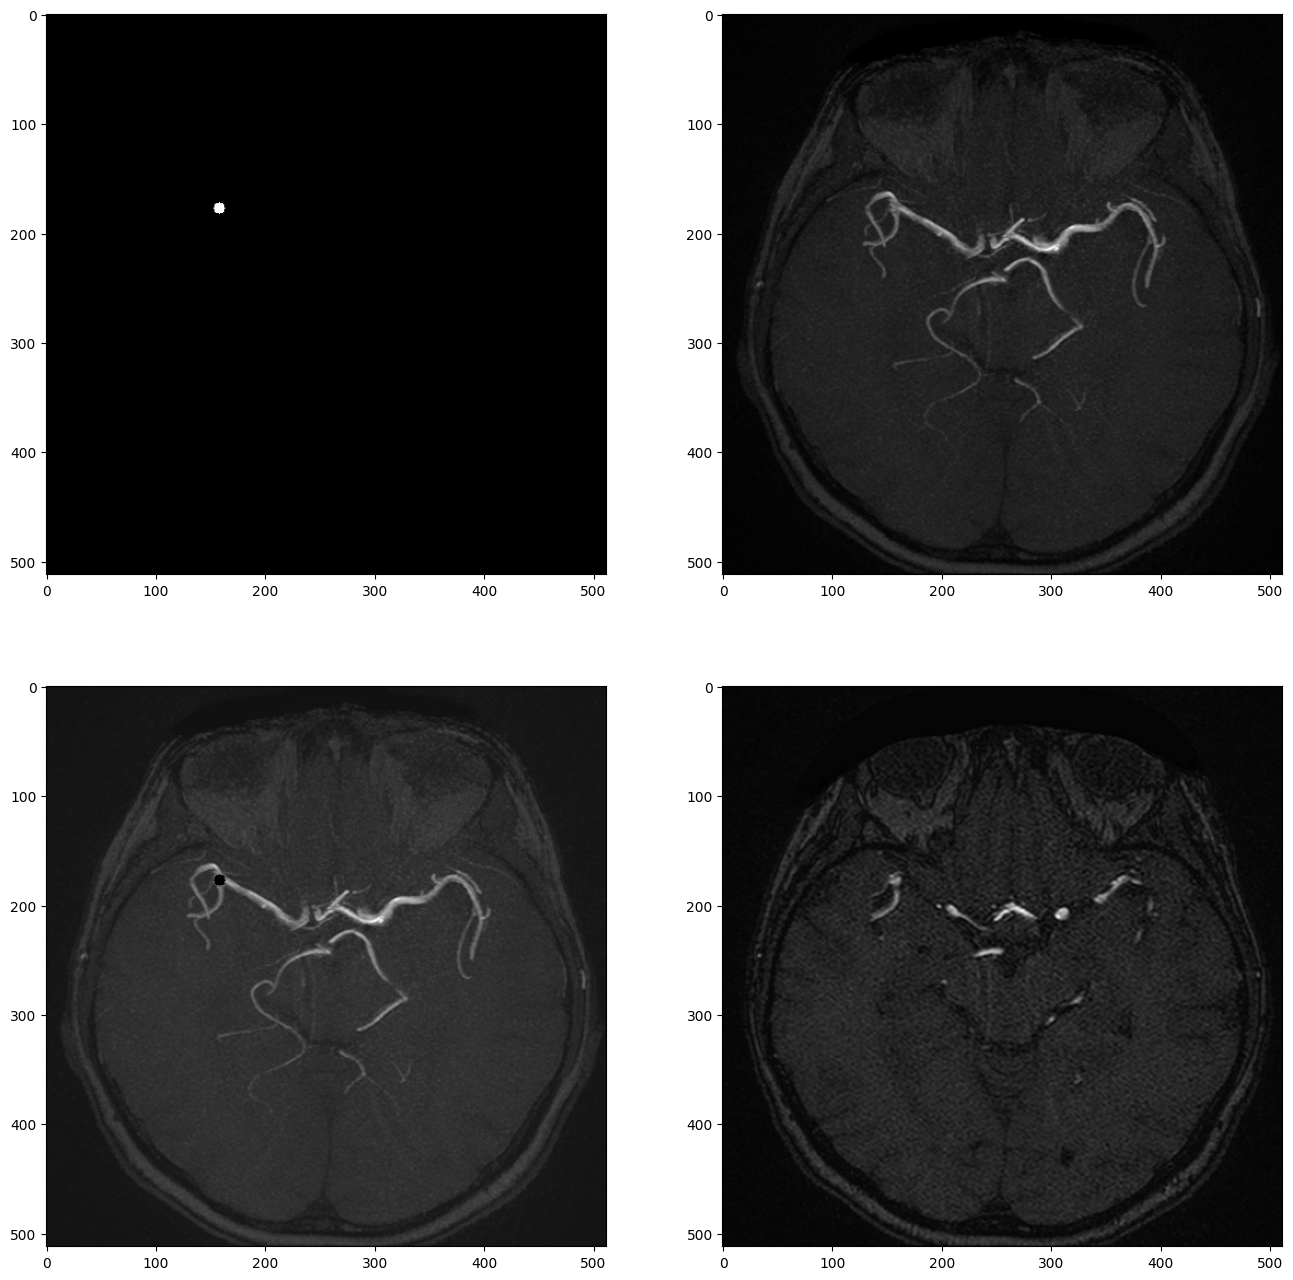

In [31]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(16,16))

axes[0, 0].imshow(mask, cmap="gray")
axes[0, 1].imshow(image[0], cmap="gray")

tmp = image[0].clone()
tmp[mask != 0] = 0
axes[1, 0].imshow(tmp, cmap="gray")
axes[1, 1].imshow(image[1], cmap="gray")

In [16]:
# image.min()

In [32]:
LH, LW = torch.unravel_index(mask.argmax(), mask.shape)

In [33]:
patchstack = F.interpolate(image[:,LH-64:LH+64,LW-64:LW+64].unsqueeze(0), (256,256), mode="bilinear", align_corners=False)
slicestack = F.interpolate(image.unsqueeze(0), (256,256), mode="bilinear", align_corners=False)

In [34]:
with torch.no_grad():
    patch_logits = pl_model(torch.concat([patchstack, slicestack], dim=1).cuda())[:,1:]

In [35]:
patch_logits.softmax(dim=1), label

(tensor([[0.0491, 0.0106, 0.0103, 0.0030, 0.1035, 0.0032, 0.0046, 0.0045, 0.0184,
          0.0017, 0.7672, 0.0073, 0.0167]], device='cuda:0'),
 10)

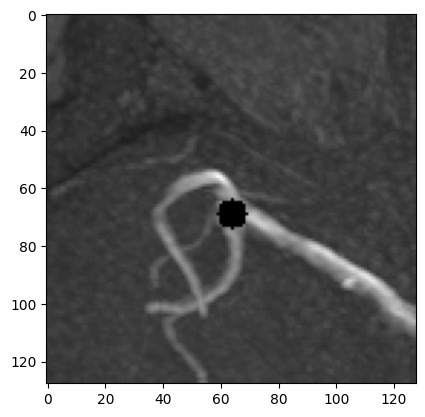

In [36]:
plt.imshow(tmp[LH-64:LH+64,LW-64:LW+64], cmap="gray")

In [37]:
LH, LW

(tensor(172), tensor(158))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

In [2]:
weird = []

In [3]:
traindf = pd.read_csv("../data/processed/train.csv")
traindf = traindf[traindf["Modality"] != "CTA"].reset_index(drop=True)

In [4]:
idx = 6
uid = traindf["SeriesInstanceUID"].iloc[idx]

In [5]:
traindf[traindf["SeriesInstanceUID"] == uid]

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present,fold_id
6,1.2.826.0.1.3680043.8.498.10101061475536996465...,53,Female,MRA,0,0,0,0,0,0,0,0,1,0,0,0,0,1,4


In [6]:
sample = np.load(f"../data/processed/{uid}.npz")
vol, coords = sample["vol"], sample["coords"]

In [11]:
z,y,x = coords[0]
z,y,x

(np.int64(201), np.int64(132), np.int64(259))

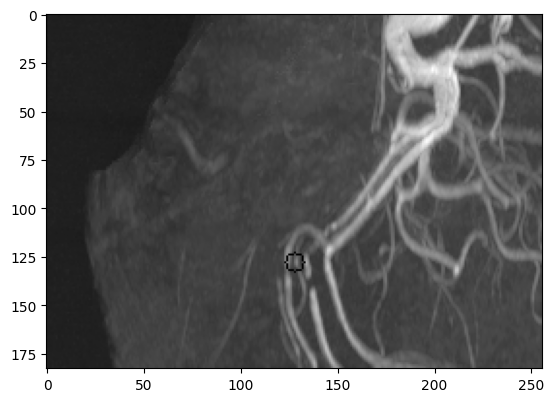

In [78]:
mipx = vol.max(axis=2)
mipx = cv2.circle(mipx, (y,z), 5, 5)
plt.imshow(mipx[z-128:z+128, y-128:y+128], cmap="gray")

(256, 512)


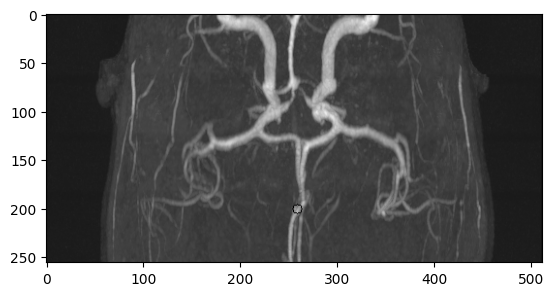

In [10]:
mipy = vol.max(axis=1)
print(mipy.shape)
mipy = cv2.circle(mipy, (x,z), 5, 5)
plt.imshow(mipy, cmap="gray")

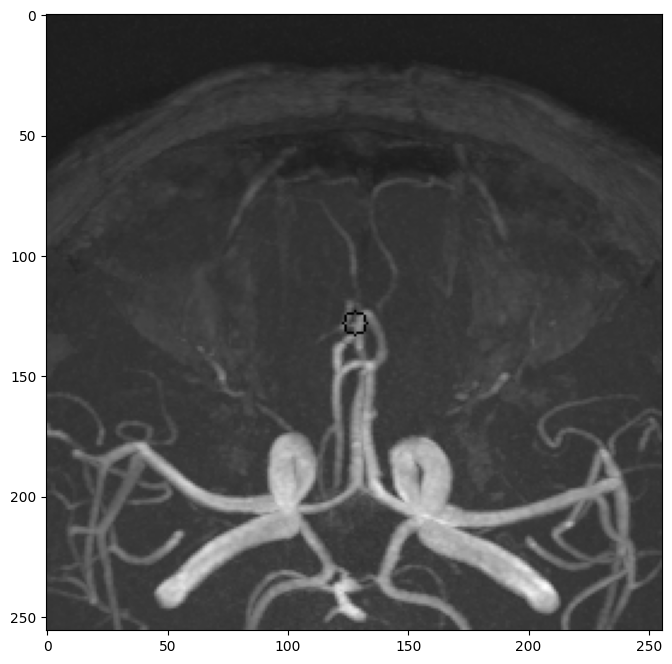

In [70]:
plt.figure(figsize=(8,8))

mip = vol.max(axis=0)
mip = cv2.circle(mip, (x,y), 5, 2)


plt.imshow(mip[y-128:y+128, x-128:x+128], cmap="gray")

In [31]:
weird.append(uid)

In [4]:
import nibabel
import numpy as np
import pandas as pd
import os

In [10]:
seg_uids = [f.split("_cowseg")[0] for f in os.listdir("../data/segmentations/") if "cow" in f]
df = pd.read_csv("../data/train.csv")
df = df[df["SeriesInstanceUID"].isin(seg_uids)]

In [23]:
idx = 1
uid = df.iloc[idx,0]
df[df["SeriesInstanceUID"] == uid]

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
27,1.2.826.0.1.3680043.8.498.10076056930521523789...,40,Female,MRA,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [24]:
seg = nibabel.load(f"../data/segmentations/{uid}.nii")

In [25]:
arr = np.array(seg.get_fdata())

In [26]:
arr.max()

np.float64(1064.0)

In [27]:
arr.shape

(1024, 1024, 136)